In [1]:
import random
import numpy as np
import pandas as pd
import polars as pl

In [2]:
import glob
import os
from os import listdir, walk
from os.path import join, split

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import sklearn as sk
from sklearn.metrics import brier_score_loss
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [5]:
class CFG:
    random_seed = 42
    dir = "/home/nick/Projects/kaggle/march_mania_24/data/"

In [6]:
def load_df(df_name, describe=False):
    df = pl.read_csv(join(CFG.dir, f"{df_name}.csv"), ignore_errors=True)
    print("\n"+"*"*50)
    print(f"DATASET NAME: {df_name}")
    print(f"SHAPE: {df.shape}")
    print(f"\nMEMORY USAGE: {df.estimated_size('b')} bytes")
    print("\nDISPLAY\n")
    display(df.head(3))
    if describe:
        print("\nDESCRIBE\n")
        display(df.describe())
    return df

In [7]:
mTourneyResults = load_df('MNCAATourneyDetailedResults')
mTourneyResults = mTourneyResults.with_columns(
    pl.when(mTourneyResults['DayNum'].is_in(range(134, 136))).then(pl.lit(0))
    .when(mTourneyResults['DayNum'].is_in(range(136, 138))).then(pl.lit(1))
    .when(mTourneyResults['DayNum'].is_in(range(138, 140))).then(pl.lit(2))
    .when(mTourneyResults['DayNum'].is_in(range(143, 145))).then(pl.lit(3))
    .when(mTourneyResults['DayNum'].is_in(range(145, 147))).then(pl.lit(4))
    .when(mTourneyResults['DayNum'] == 152).then(pl.lit(5))
    .when(mTourneyResults['DayNum'] == 154).then(pl.lit(6))
    .otherwise(pl.lit(-1))
    .alias('Round')
)
y_cols = ['Season', 'Round', 'WTeamID', 'LTeamID']
y_df = mTourneyResults.select(y_cols)
# randomly shuffle the team ids

def random_shuffle(row):
    if np.random.rand() < 0.5:
        return pl.Series([row[2], row[3]])
    else:
        return pl.Series([row[3], row[2]])

new_df = y_df.map_rows(random_shuffle)
new_df = y_df.hstack(new_df)

# Splitting the 'map' column into two separate columns
new_df = new_df.with_columns(pl.col("map").map_elements(lambda x: x[0], return_dtype=pl.Int64).alias("TeamID1"))
new_df = new_df.with_columns(pl.col("map").map_elements(lambda x: x[1], return_dtype=pl.Int64).alias("TeamID2"))

# Dropping the original 'map' column
new_df = new_df.drop("map")

y_df = new_df

print(y_df)


**************************************************
DATASET NAME: MNCAATourneyDetailedResults
SHAPE: (1315, 34)

MEMORY USAGE: 368200 bytes

DISPLAY



Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
2003,134,1421,92,1411,84,"""N""",1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
2003,136,1112,80,1436,51,"""N""",0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2003,136,1113,84,1272,71,"""N""",0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18


shape: (1_315, 6)
┌────────┬───────┬─────────┬─────────┬─────────┬─────────┐
│ Season ┆ Round ┆ WTeamID ┆ LTeamID ┆ TeamID1 ┆ TeamID2 │
│ ---    ┆ ---   ┆ ---     ┆ ---     ┆ ---     ┆ ---     │
│ i64    ┆ i32   ┆ i64     ┆ i64     ┆ i64     ┆ i64     │
╞════════╪═══════╪═════════╪═════════╪═════════╪═════════╡
│ 2003   ┆ 0     ┆ 1421    ┆ 1411    ┆ 1411    ┆ 1421    │
│ 2003   ┆ 1     ┆ 1112    ┆ 1436    ┆ 1112    ┆ 1436    │
│ 2003   ┆ 1     ┆ 1113    ┆ 1272    ┆ 1272    ┆ 1113    │
│ 2003   ┆ 1     ┆ 1141    ┆ 1166    ┆ 1141    ┆ 1166    │
│ 2003   ┆ 1     ┆ 1143    ┆ 1301    ┆ 1143    ┆ 1301    │
│ …      ┆ …     ┆ …       ┆ …       ┆ …       ┆ …       │
│ 2023   ┆ 4     ┆ 1274    ┆ 1400    ┆ 1400    ┆ 1274    │
│ 2023   ┆ 4     ┆ 1361    ┆ 1166    ┆ 1166    ┆ 1361    │
│ 2023   ┆ 5     ┆ 1163    ┆ 1274    ┆ 1274    ┆ 1163    │
│ 2023   ┆ 5     ┆ 1361    ┆ 1194    ┆ 1194    ┆ 1361    │
│ 2023   ┆ 6     ┆ 1163    ┆ 1361    ┆ 1163    ┆ 1361    │
└────────┴───────┴─────────┴─────────┴

In [8]:
mSeasonAverages = load_df('MRegSeaAvg')
print(mSeasonAverages)


**************************************************
DATASET NAME: MRegSeaAvg
SHAPE: (7617, 33)

MEMORY USAGE: 2010888 bytes

DISPLAY



Season,TeamID,Score_avg,OppScore_avg,FGM_avg,OppFGM_avg,FGA_avg,OppFGA_avg,FGM3_avg,OppFGM3_avg,FGA3_avg,OppFGA3_avg,FTM_avg,OppFTM_avg,FTA_avg,OppFTA_avg,OR_avg,OppOR_avg,DR_avg,OppDR_avg,Ast_avg,OppAst_avg,TO_avg,OppTO_avg,Stl_avg,OppStl_avg,Blk_avg,OppBlk_avg,PF_avg,OppPF_avg,WinCount,LossCount,WinPct
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64
2014,1101,63.142857,78.619048,20.333333,27.142857,50.142857,53.428571,6.666667,6.0,17.857143,16.190476,15.809524,18.333333,21.190476,25.809524,8.0,10.380952,20.333333,24.095238,10.0,15.571429,15.0,12.142857,5.761905,7.0,1.47619,5.0,21.571429,18.666667,2,19,0.095238
2015,1101,61.0,71.857143,21.428571,25.035714,52.928571,50.857143,7.25,6.178571,19.178571,16.714286,10.892857,15.607143,14.964286,22.714286,8.25,10.035714,19.642857,25.892857,11.857143,12.928571,12.821429,13.464286,5.928571,5.857143,1.178571,4.25,20.607143,16.535714,7,21,0.25
2016,1101,69.851852,76.259259,23.814815,26.481481,53.925926,53.666667,6.851852,5.592593,18.851852,15.148148,15.37037,17.703704,21.740741,24.962963,8.185185,8.592593,22.518519,25.222222,12.888889,12.851852,13.407407,13.444444,6.740741,5.111111,2.444444,3.296296,22.37037,19.666667,9,18,0.333333


shape: (7_617, 33)
┌────────┬────────┬───────────┬──────────────┬───┬───────────┬──────────┬───────────┬──────────┐
│ Season ┆ TeamID ┆ Score_avg ┆ OppScore_avg ┆ … ┆ OppPF_avg ┆ WinCount ┆ LossCount ┆ WinPct   │
│ ---    ┆ ---    ┆ ---       ┆ ---          ┆   ┆ ---       ┆ ---      ┆ ---       ┆ ---      │
│ i64    ┆ i64    ┆ f64       ┆ f64          ┆   ┆ f64       ┆ i64      ┆ i64       ┆ f64      │
╞════════╪════════╪═══════════╪══════════════╪═══╪═══════════╪══════════╪═══════════╪══════════╡
│ 2014   ┆ 1101   ┆ 63.142857 ┆ 78.619048    ┆ … ┆ 18.666667 ┆ 2        ┆ 19        ┆ 0.095238 │
│ 2015   ┆ 1101   ┆ 61.0      ┆ 71.857143    ┆ … ┆ 16.535714 ┆ 7        ┆ 21        ┆ 0.25     │
│ 2016   ┆ 1101   ┆ 69.851852 ┆ 76.259259    ┆ … ┆ 19.666667 ┆ 9        ┆ 18        ┆ 0.333333 │
│ 2017   ┆ 1101   ┆ 67.88     ┆ 72.64        ┆ … ┆ 17.24     ┆ 9        ┆ 16        ┆ 0.36     │
│ 2018   ┆ 1101   ┆ 70.666667 ┆ 72.814815    ┆ … ┆ 17.666667 ┆ 12       ┆ 15        ┆ 0.444444 │
│ …      ┆ 

In [9]:

mseason_columns = mSeasonAverages.columns

# Merge mSeasonAverages with y_df for TeamID1
merged_df_team1 = y_df\
    .join(mSeasonAverages, 
          left_on=['Season', 'TeamID1'], 
          right_on=['Season', 'TeamID'], 
          how='left')

# Columns to exclude
columns_to_exclude1 = ['Season', 'Round', 'WTeamID', 'LTeamID', 'TeamID1', 'TeamID2']

# Get the columns to rename
columns_to_rename1 = [col for col in merged_df_team1.columns if col not in columns_to_exclude1]

# Create a mapping of old column names to new column names
column_mapping1 = {col: f"{col}_1" for col in columns_to_rename1}

# Rename the columns using the mapping
merged_df_team1 = merged_df_team1.rename(column_mapping1)

merged_df_team2 = y_df\
    .join(mSeasonAverages, 
          left_on=['Season', 'TeamID2'], 
          right_on=['Season', 'TeamID'], 
          how='left')

# Columns to exclude
columns_to_exclude2 = ['Season', 'Round', 'WTeamID', 'LTeamID', 'TeamID1', 'TeamID2']

# Get the columns to rename
columns_to_rename2 = [col for col in merged_df_team2.columns if col not in columns_to_exclude2]

# Create a mapping of old column names to new column names
column_mapping2 = {col: f"{col}_2" for col in columns_to_rename2}

# Rename the columns using the mapping
merged_df_team2 = merged_df_team2.rename(column_mapping2)

In [10]:
columns_to_drop1 = ['WTeamID', 'LTeamID', 'TeamID1', 'TeamID2']
columns_to_drop2 = ['Season', 'Round', 'WTeamID', 'LTeamID', 'TeamID1', 'TeamID2']

X1 = merged_df_team1.drop(columns_to_drop1)
X2 = merged_df_team2.drop(columns_to_drop2)

In [11]:
X_df = X1.hstack(X2)

In [12]:
X_df

Season,Round,Score_avg_1,OppScore_avg_1,FGM_avg_1,OppFGM_avg_1,FGA_avg_1,OppFGA_avg_1,FGM3_avg_1,OppFGM3_avg_1,FGA3_avg_1,OppFGA3_avg_1,FTM_avg_1,OppFTM_avg_1,FTA_avg_1,OppFTA_avg_1,OR_avg_1,OppOR_avg_1,DR_avg_1,OppDR_avg_1,Ast_avg_1,OppAst_avg_1,TO_avg_1,OppTO_avg_1,Stl_avg_1,OppStl_avg_1,Blk_avg_1,OppBlk_avg_1,PF_avg_1,OppPF_avg_1,WinCount_1,LossCount_1,WinPct_1,Score_avg_2,OppScore_avg_2,FGM_avg_2,OppFGM_avg_2,FGA_avg_2,OppFGA_avg_2,FGM3_avg_2,OppFGM3_avg_2,FGA3_avg_2,OppFGA3_avg_2,FTM_avg_2,OppFTM_avg_2,FTA_avg_2,OppFTA_avg_2,OR_avg_2,OppOR_avg_2,DR_avg_2,OppDR_avg_2,Ast_avg_2,OppAst_avg_2,TO_avg_2,OppTO_avg_2,Stl_avg_2,OppStl_avg_2,Blk_avg_2,OppBlk_avg_2,PF_avg_2,OppPF_avg_2,WinCount_2,LossCount_2,WinPct_2
i64,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64
2003,0,72.8,70.833333,24.733333,25.666667,55.266667,60.4,5.933333,7.533333,18.5,23.166667,17.4,11.966667,28.066667,18.733333,13.166667,11.933333,24.8,22.866667,14.2,13.766667,15.233333,14.333333,6.433333,8.0,2.233333,2.6,18.3,21.633333,18,12,0.6,71.206897,78.448276,24.37931,27.793103,56.793103,60.965517,6.482759,7.62069,18.0,20.758621,15.965517,15.241379,20.931034,22.551724,12.275862,13.724138,23.172414,22.827586,13.034483,15.862069,16.206897,12.827586,7.068966,8.827586,3.0,4.241379,19.103448,18.689655,13,16,0.448276
2003,1,85.214286,70.25,30.321429,26.357143,65.714286,64.678571,7.035714,6.321429,20.071429,19.964286,17.535714,11.214286,25.0,17.714286,15.178571,13.107143,27.642857,23.285714,17.642857,15.464286,14.785714,16.857143,8.464286,5.964286,4.214286,2.392857,17.75,22.071429,25,3,0.892857,67.793103,63.137931,24.827586,22.758621,55.862069,55.068966,5.275862,7.068966,15.482759,21.448276,12.862069,10.551724,19.551724,15.758621,12.965517,9.586207,25.724138,21.862069,14.206897,13.275862,14.068966,13.0,6.862069,7.103448,2.965517,3.655172,15.896552,17.931034,19,10,0.655172
2003,1,74.517241,65.827586,26.275862,23.275862,60.0,57.862069,7.0,5.896552,20.068966,18.310345,14.965517,13.37931,22.896552,20.724138,14.068966,12.344828,25.965517,23.586207,16.62069,13.310345,13.793103,15.068966,7.37931,7.275862,5.068966,3.172414,18.758621,19.931034,23,6,0.793103,75.965517,69.172414,27.206897,24.793103,56.896552,55.655172,4.0,5.448276,12.586207,15.896552,17.551724,14.137931,26.206897,20.517241,13.689655,11.0,23.310345,20.551724,15.551724,14.068966,14.0,15.517241,5.206897,6.0,4.241379,3.931034,19.413793,22.862069,18,11,0.62069
2003,1,79.344828,73.241379,26.62069,26.344828,52.689655,57.931034,6.827586,4.965517,17.931034,13.896552,19.275862,15.586207,25.172414,21.965517,10.586207,12.241379,23.275862,18.896552,15.62069,11.793103,18.241379,16.068966,7.103448,8.448276,4.0,2.482759,20.965517,21.689655,23,6,0.793103,79.242424,64.333333,28.69697,23.878788,57.454545,55.333333,7.969697,4.878788,20.484848,14.30303,13.878788,11.69697,20.030303,16.69697,10.878788,11.060606,23.181818,21.363636,16.818182,12.363636,13.363636,17.060606,8.393939,6.333333,4.454545,2.575758,17.272727,19.393939,29,4,0.878788
2003,1,74.482759,69.758621,27.344828,25.37931,58.724138,58.793103,6.413793,7.103448,17.034483,21.448276,13.37931,11.896552,19.517241,17.448276,11.241379,11.172414,24.37931,23.0,16.0,16.034483,14.172414,14.931034,6.551724,5.931034,2.793103,2.517241,17.103448,19.103448,21,8,0.724138,72.4,68.0,24.333333,23.433333,53.333333,53.133333,7.966667,5.733333,22.5,17.0,15.766667,15.4,20.466667,21.2,9.733333,10.533333,22.033333,21.433333,14.666667,12.566667,14.2,14.633333,7.766667,7.433333,3.066667,2.833333,18.666667,19.333333,18,12,0.6
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2023,4,77.852941,67.411765,28.205882,23.5,60.176471,55.882353,7.147059,6.470588,21.088235,19.794118,14.294118,13.941176,19.0,19.264706,8.588235,8.411765,23

In [13]:
y_label_df = y_df.with_columns(
    pl.when(y_df['WTeamID'] == y_df['TeamID1']).then(1).otherwise(0).alias('result')
)
y_label_df = y_label_df.drop('Season', 'Round', 'WTeamID', 'LTeamID', 'TeamID1', 'TeamID2')
y_label_df

result
i32
0
1
0
1
1
…
0
0
0


In [14]:
X_df

Season,Round,Score_avg_1,OppScore_avg_1,FGM_avg_1,OppFGM_avg_1,FGA_avg_1,OppFGA_avg_1,FGM3_avg_1,OppFGM3_avg_1,FGA3_avg_1,OppFGA3_avg_1,FTM_avg_1,OppFTM_avg_1,FTA_avg_1,OppFTA_avg_1,OR_avg_1,OppOR_avg_1,DR_avg_1,OppDR_avg_1,Ast_avg_1,OppAst_avg_1,TO_avg_1,OppTO_avg_1,Stl_avg_1,OppStl_avg_1,Blk_avg_1,OppBlk_avg_1,PF_avg_1,OppPF_avg_1,WinCount_1,LossCount_1,WinPct_1,Score_avg_2,OppScore_avg_2,FGM_avg_2,OppFGM_avg_2,FGA_avg_2,OppFGA_avg_2,FGM3_avg_2,OppFGM3_avg_2,FGA3_avg_2,OppFGA3_avg_2,FTM_avg_2,OppFTM_avg_2,FTA_avg_2,OppFTA_avg_2,OR_avg_2,OppOR_avg_2,DR_avg_2,OppDR_avg_2,Ast_avg_2,OppAst_avg_2,TO_avg_2,OppTO_avg_2,Stl_avg_2,OppStl_avg_2,Blk_avg_2,OppBlk_avg_2,PF_avg_2,OppPF_avg_2,WinCount_2,LossCount_2,WinPct_2
i64,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64
2003,0,72.8,70.833333,24.733333,25.666667,55.266667,60.4,5.933333,7.533333,18.5,23.166667,17.4,11.966667,28.066667,18.733333,13.166667,11.933333,24.8,22.866667,14.2,13.766667,15.233333,14.333333,6.433333,8.0,2.233333,2.6,18.3,21.633333,18,12,0.6,71.206897,78.448276,24.37931,27.793103,56.793103,60.965517,6.482759,7.62069,18.0,20.758621,15.965517,15.241379,20.931034,22.551724,12.275862,13.724138,23.172414,22.827586,13.034483,15.862069,16.206897,12.827586,7.068966,8.827586,3.0,4.241379,19.103448,18.689655,13,16,0.448276
2003,1,85.214286,70.25,30.321429,26.357143,65.714286,64.678571,7.035714,6.321429,20.071429,19.964286,17.535714,11.214286,25.0,17.714286,15.178571,13.107143,27.642857,23.285714,17.642857,15.464286,14.785714,16.857143,8.464286,5.964286,4.214286,2.392857,17.75,22.071429,25,3,0.892857,67.793103,63.137931,24.827586,22.758621,55.862069,55.068966,5.275862,7.068966,15.482759,21.448276,12.862069,10.551724,19.551724,15.758621,12.965517,9.586207,25.724138,21.862069,14.206897,13.275862,14.068966,13.0,6.862069,7.103448,2.965517,3.655172,15.896552,17.931034,19,10,0.655172
2003,1,74.517241,65.827586,26.275862,23.275862,60.0,57.862069,7.0,5.896552,20.068966,18.310345,14.965517,13.37931,22.896552,20.724138,14.068966,12.344828,25.965517,23.586207,16.62069,13.310345,13.793103,15.068966,7.37931,7.275862,5.068966,3.172414,18.758621,19.931034,23,6,0.793103,75.965517,69.172414,27.206897,24.793103,56.896552,55.655172,4.0,5.448276,12.586207,15.896552,17.551724,14.137931,26.206897,20.517241,13.689655,11.0,23.310345,20.551724,15.551724,14.068966,14.0,15.517241,5.206897,6.0,4.241379,3.931034,19.413793,22.862069,18,11,0.62069
2003,1,79.344828,73.241379,26.62069,26.344828,52.689655,57.931034,6.827586,4.965517,17.931034,13.896552,19.275862,15.586207,25.172414,21.965517,10.586207,12.241379,23.275862,18.896552,15.62069,11.793103,18.241379,16.068966,7.103448,8.448276,4.0,2.482759,20.965517,21.689655,23,6,0.793103,79.242424,64.333333,28.69697,23.878788,57.454545,55.333333,7.969697,4.878788,20.484848,14.30303,13.878788,11.69697,20.030303,16.69697,10.878788,11.060606,23.181818,21.363636,16.818182,12.363636,13.363636,17.060606,8.393939,6.333333,4.454545,2.575758,17.272727,19.393939,29,4,0.878788
2003,1,74.482759,69.758621,27.344828,25.37931,58.724138,58.793103,6.413793,7.103448,17.034483,21.448276,13.37931,11.896552,19.517241,17.448276,11.241379,11.172414,24.37931,23.0,16.0,16.034483,14.172414,14.931034,6.551724,5.931034,2.793103,2.517241,17.103448,19.103448,21,8,0.724138,72.4,68.0,24.333333,23.433333,53.333333,53.133333,7.966667,5.733333,22.5,17.0,15.766667,15.4,20.466667,21.2,9.733333,10.533333,22.033333,21.433333,14.666667,12.566667,14.2,14.633333,7.766667,7.433333,3.066667,2.833333,18.666667,19.333333,18,12,0.6
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2023,4,77.852941,67.411765,28.205882,23.5,60.176471,55.882353,7.147059,6.470588,21.088235,19.794118,14.294118,13.941176,19.0,19.264706,8.588235,8.411765,23

In [15]:
# covert X and y to np arrays
X = X_df.to_numpy()
y = y_label_df.to_numpy()


In [16]:
# weigting function to have more focus on recent Seasons
def calculate_weights(X):
    current_year = 2023
    years_since = current_year - X[:,0]
    weights = np.exp(-0.0 * years_since)
    return weights

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.ravel()
y_test = y_test.ravel()

train_weights = calculate_weights(X_train)

logistic = LogisticRegression(max_iter=10000)
logistic.fit(X_train, y_train, sample_weight=train_weights)
y_pred = logistic.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

Logistic Regression Accuracy: 0.6615969581749049


In [17]:
# normalize
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

Epoch [10/350], Train Loss: 0.6781, Test Loss: 0.6789
Epoch [20/350], Train Loss: 0.6707, Test Loss: 0.6715
Epoch [30/350], Train Loss: 0.6631, Test Loss: 0.6638
Epoch [40/350], Train Loss: 0.6553, Test Loss: 0.6559
Epoch [50/350], Train Loss: 0.6475, Test Loss: 0.6478
Epoch [60/350], Train Loss: 0.6396, Test Loss: 0.6398
Epoch [70/350], Train Loss: 0.6320, Test Loss: 0.6321
Epoch [80/350], Train Loss: 0.6248, Test Loss: 0.6250
Epoch [90/350], Train Loss: 0.6180, Test Loss: 0.6189
Epoch [100/350], Train Loss: 0.6118, Test Loss: 0.6135
Epoch [110/350], Train Loss: 0.6059, Test Loss: 0.6091
Epoch [120/350], Train Loss: 0.6005, Test Loss: 0.6053
Epoch [130/350], Train Loss: 0.5955, Test Loss: 0.6020
Epoch [140/350], Train Loss: 0.5909, Test Loss: 0.5991
Epoch [150/350], Train Loss: 0.5867, Test Loss: 0.5968
Epoch [160/350], Train Loss: 0.5828, Test Loss: 0.5948
Epoch [170/350], Train Loss: 0.5793, Test Loss: 0.5932
Epoch [180/350], Train Loss: 0.5760, Test Loss: 0.5920
Epoch [190/350], Tr

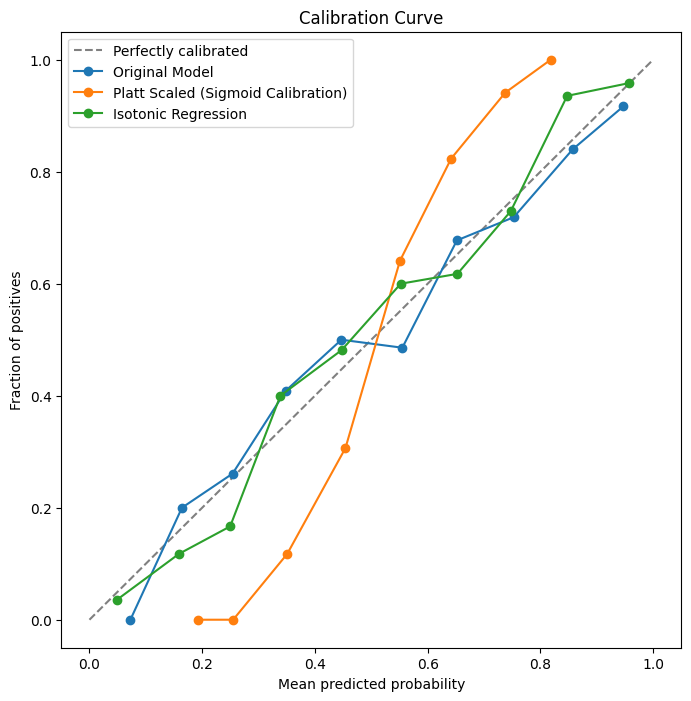

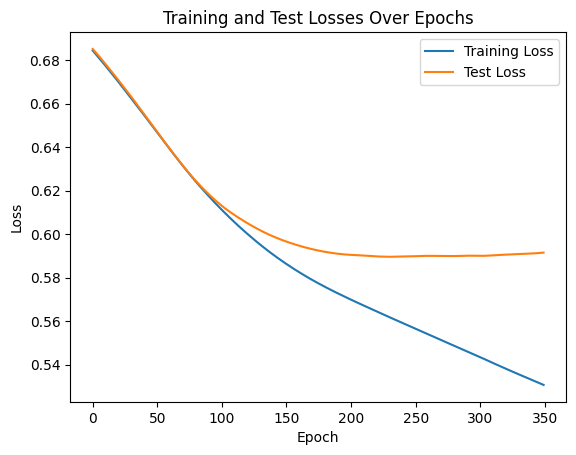

Original Model Brier Score: 0.2049
Platt Scaled (Sigmoid Calibration) Model Brier Score: 0.1864
Isotonic Regression Model Brier Score: 0.1548
Original Model Accuracy: 0.6198
Platt Scaled (Sigmoid Calibration) Model Accuracy: 0.7681
Isotonic Regression Model Accuracy: 0.7681


In [35]:
# Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
                 super(NeuralNetwork, self).__init__()
                 self.fc1 = nn.Linear(input_size, hidden_size)
                 self.relu = nn.ReLU()
                 self.fc2 = nn.Linear(hidden_size, output_size)
                 self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


input_size = X_train.shape[1]
hidden_size = 8
output_size = 1

model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Lists to store training and test losses
train_losses = []
test_losses = []

num_epochs = 350
for epoch in range(num_epochs):
    # Training phase
    model.train()
    inputs = torch.tensor(X_train_normalized, dtype=torch.float32)
    labels = torch.tensor(y_train, dtype=torch.float32)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels.view(-1, 1))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        test_inputs = torch.tensor(X_test_normalized, dtype=torch.float32)
        test_labels = torch.tensor(y_test, dtype=torch.float32)
        test_outputs = model(test_inputs)
        test_loss = criterion(test_outputs, test_labels.view(-1, 1))
        test_losses.append(test_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

calibrated_model = CalibratedClassifierCV(LogisticRegression(max_iter=5000), method='sigmoid')
calibrated_model.fit(X_test, y_test)

brier_score = brier_score_loss(y_test, test_outputs)

# Evaluate the calibrated model
calibrated_probabilities = calibrated_model.predict_proba(X_test)[:, 1]
calibrated_predictions = (calibrated_probabilities >= 0.5).astype(int)
calibrated_accuracy = accuracy_score(y_test, calibrated_predictions)
print(f'Calibrated Test Accuracy: {calibrated_accuracy:.4f}')

# Original model calibration curve
prob_true, prob_pred = calibration_curve(y_test, test_outputs.numpy(), n_bins=10)

# Calibrated model calibration curve
calibrated_prob_true, calibrated_prob_pred = calibration_curve(y_test, calibrated_probabilities, n_bins=10)

calibrated_brier_score = brier_score_loss(y_test, calibrated_probabilities)

isotonic_model = IsotonicRegression(out_of_bounds='clip')
isotonic_model.fit(calibrated_prob_pred, calibrated_prob_true)

# Apply isotonic regression to get calibrated probabilities
isotonic_calibrated_probabilities = isotonic_model.predict(calibrated_probabilities)

# Compute accuracy and Brier score for the isotonic calibrated model
isotonic_calibrated_predictions = (isotonic_calibrated_probabilities >= 0.5).astype(int)
isotonic_calibrated_accuracy = accuracy_score(y_test, isotonic_calibrated_predictions)
isotonic_calibrated_brier_score = brier_score_loss(y_test, isotonic_calibrated_probabilities)

# Compute calibration curve for the isotonic calibrated model
isotonic_prob_true, isotonic_prob_pred = calibration_curve(y_test, isotonic_calibrated_probabilities, n_bins=10)

# Plot calibration curves
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')  # Perfect calibration line
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Original Model')  # Original model calibration curve
plt.plot(calibrated_prob_pred, calibrated_prob_true, marker='o', linestyle='-', label='Platt Scaled (Sigmoid Calibration)')  # Platt scaled calibration curve
plt.plot(isotonic_prob_pred, isotonic_prob_true, marker='o', linestyle='-', label='Isotonic Regression')  # Isotonic regression calibration curve
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses Over Epochs')
plt.legend()
plt.show()

# Print performance metrics
print(f'Original Model Brier Score: {brier_score:.4f}')
print(f'Platt Scaled (Sigmoid Calibration) Model Brier Score: {calibrated_brier_score:.4f}')
print(f'Isotonic Regression Model Brier Score: {isotonic_calibrated_brier_score:.4f}')
print(f'Original Model Accuracy: {accuracy:.4f}')
print(f'Platt Scaled (Sigmoid Calibration) Model Accuracy: {calibrated_accuracy:.4f}')
print(f'Isotonic Regression Model Accuracy: {isotonic_calibrated_accuracy:.4f}')